In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import os
import random
from numpy.random import seed

seed_val = 4
seed(seed_val)

# tensorflow libraries
import tensorflow as tf
tf.random.set_seed(seed_val)

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from datetime import datetime
import time

import pylab as plt

# Read Data

In [2]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

blues        100
pop          100
rock         100
hiphop       100
classical    100
reggae       100
country      100
disco        100
metal        100
jazz         100
Name: label, dtype: int64

Split and scale dataset

In [4]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


# Question 1

Design a feedforward deep neural network (DNN) which consists of an input layer, one
hidden layer of 16 neurons with ReLU activation function, and an output softmax layer.
Use an stochastic gradient descent with ‘adam’ optimizer with default parameters, and
batch size = 1. Apply dropout of probability 0.3 to the hidden layer.<br><br>
Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of
input features. We solely assume that there are only two datasets here: training & test.
We would look into validation in Question 2 onwards.

---------------------------------------------------------------------------------------------------

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(16 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 1 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>
<b>Callback</b>: EarlyStopping <br>

## Part (a) 

Use the training dataset to train the model for 50 epochs. Note: Use 50
epochs for subsequent experiments.

In [6]:
# Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [7]:
# Sequential Model
model = Sequential()

# Add layers to the model with dropouts and activation functions
model.add(Dense(16, input_shape=(X_train.shape[1],), activation="relu")) 
model.add(Dropout(0.3))                                                  
model.add(Dense(10, activation="softmax"))                               

# Add optimizer, loss function and metrics to monitor
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# Train model
history = model.fit(X_train, y_train,  
                    batch_size=1,      
                    epochs=50,         
                    validation_data=(X_test, y_test),     
                    callbacks=[early_stopping_callback])  

Epoch 1/50
700/700 [==============================] - 1s 1ms/step - loss: 2.2767 - accuracy: 0.2114 - val_loss: 1.8162 - val_accuracy: 0.3433
Epoch 2/50
700/700 [==============================] - 1s 882us/step - loss: 1.7127 - accuracy: 0.3900 - val_loss: 1.5403 - val_accuracy: 0.4367
Epoch 3/50
700/700 [==============================] - 1s 891us/step - loss: 1.4890 - accuracy: 0.4929 - val_loss: 1.3906 - val_accuracy: 0.5333
Epoch 4/50
700/700 [==============================] - 1s 888us/step - loss: 1.3454 - accuracy: 0.5300 - val_loss: 1.2812 - val_accuracy: 0.5400
Epoch 5/50
700/700 [==============================] - 1s 904us/step - loss: 1.2443 - accuracy: 0.5643 - val_loss: 1.2152 - val_accuracy: 0.5467
Epoch 6/50
700/700 [==============================] - 1s 874us/step - loss: 1.2024 - accuracy: 0.5643 - val_loss: 1.1684 - val_accuracy: 0.5600
Epoch 7/50
700/700 [==============================] - 1s 883us/step - loss: 1.1456 - accuracy: 0.6029 - val_loss: 1.1370 - val_accuracy: 0

## Part (b) 

Plot accuracies on training and test data against training epochs and
comment on the plots.

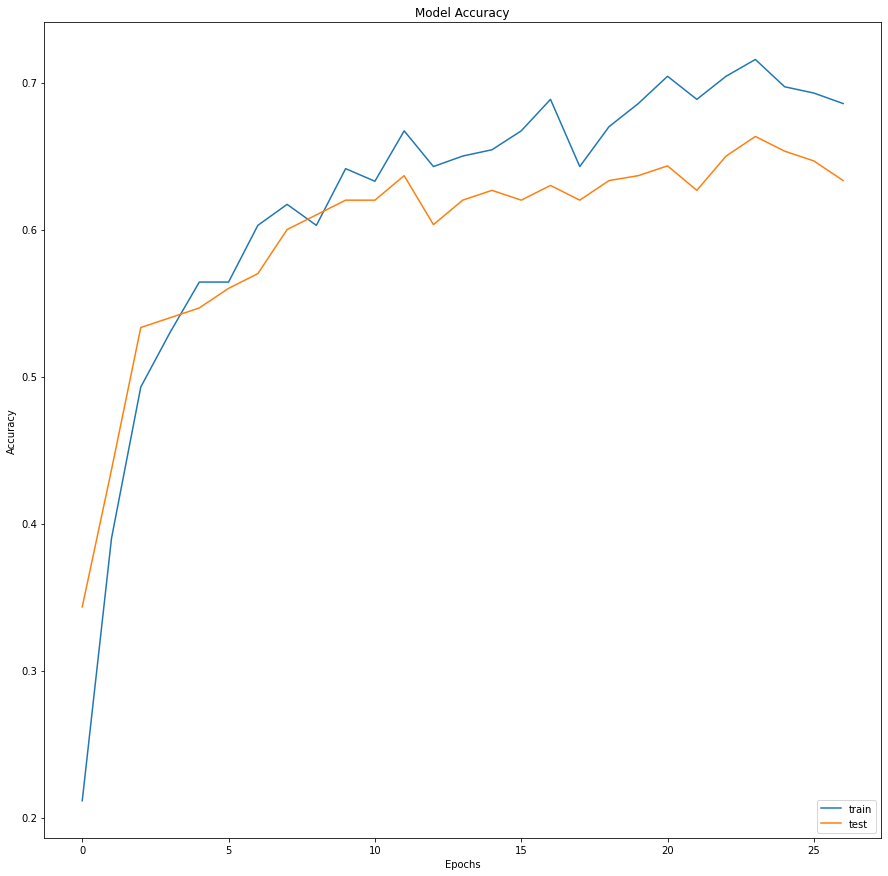

In [8]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='lower right')

#### Insights:

The train and validation accuracy have close values. We can say that the model is good and is not overfitting. If the model was overfitting, the train accuracy would be high and test accuracy would be low.

## Part (c) 

Plot the losses on training and test data against training epochs. State the
approximate number of epochs where the test error begins to converge.

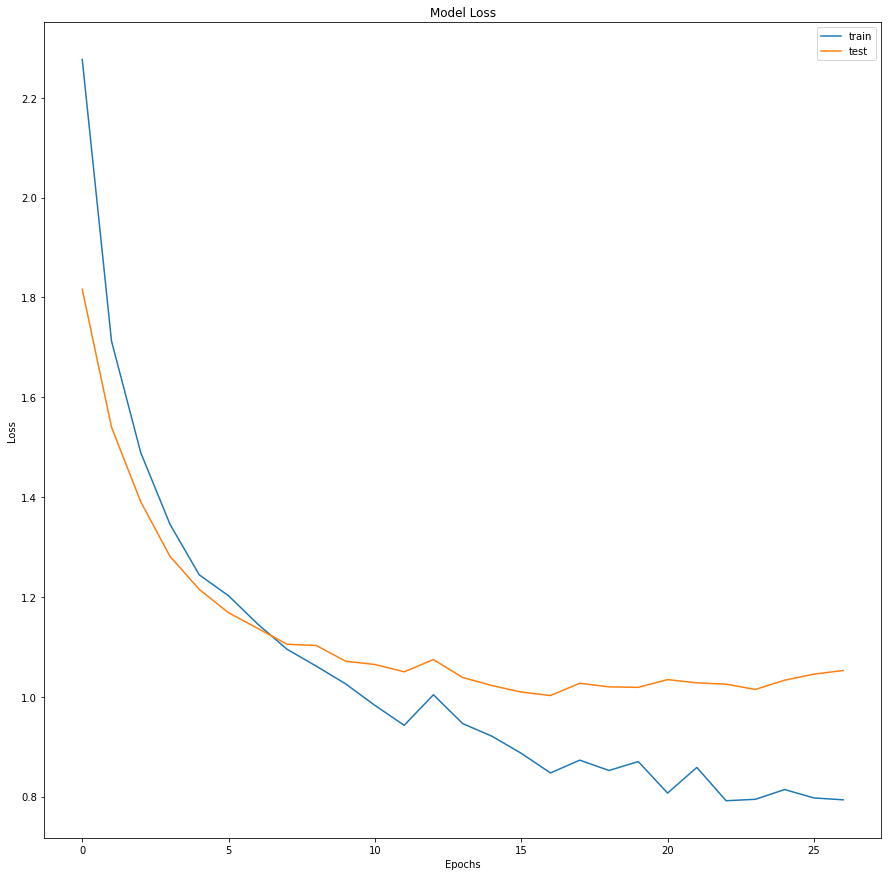

In [9]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='upper right')

#### Insights:

It can be seen from the above plot that val loss begins to converge at 15 epochs to approximately loss value of 1.

# Question 2

In this question, we will compare the performance of the model using stochastic gradient
descent and mini-batch gradient descent, as well as determining the optimal batch size
for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient
descent by training the neural network and evaluating the performances for different
batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter
selection.

---------------------------------------------------------------------------------------------------

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(16 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 1, 4, 8, 16, 32, 64 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>
<b>Callback</b>: Timing (To calculate time taken for each epoch) <br>
<b>Cross Validation(KFold)</b>: 3-fold CV used for parameter selection

In [10]:
class time_callback(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
        
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time()-self.starttime)

In [11]:
accuracy_all = {}
loss_all = {}
time_taken_all = {}

batch_sizes = [1,4,8,16,32,64]

for batch in batch_sizes:

    accuracy = []
    loss = []
    time_list = []

    folds = KFold(n_splits=3, random_state=1, shuffle=True)

    for train_index, test_index in folds.split(X_train):

        model = Sequential()
        
        model.add(Dense(16, input_shape=(X_train.shape[1],), activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(10, activation="softmax"))  
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        time_callbacks = time_callback()      

        history = model.fit(X_train[train_index], y_train[train_index],
                            batch_size=batch,
                            epochs=50,
                            validation_data=(X_train[test_index], y_train[test_index]),
                            validation_batch_size=batch,
                            callbacks=[time_callbacks]
                            )

        accuracy.append(history.history['val_accuracy'])
        loss.append(history.history['val_loss'])
        time_list.append(time_callbacks.times)

    accuracy_all[batch] = np.array(accuracy).mean(axis=0)
    loss_all[batch] = np.array(loss).mean(axis=0)
    time_taken_all[batch] = np.median((np.array(time_list).mean(axis=0)))

Epoch 1/50
466/466 [==============================] - 1s 1ms/step - loss: 2.2466 - accuracy: 0.2103 - val_loss: 1.8455 - val_accuracy: 0.3803
Epoch 2/50
466/466 [==============================] - 0s 975us/step - loss: 1.7552 - accuracy: 0.3627 - val_loss: 1.5761 - val_accuracy: 0.4786
Epoch 3/50
466/466 [==============================] - 0s 951us/step - loss: 1.5373 - accuracy: 0.4528 - val_loss: 1.4388 - val_accuracy: 0.5256
Epoch 4/50
466/466 [==============================] - 0s 926us/step - loss: 1.4035 - accuracy: 0.5150 - val_loss: 1.3347 - val_accuracy: 0.5513
Epoch 5/50
466/466 [==============================] - 0s 982us/step - loss: 1.3372 - accuracy: 0.5172 - val_loss: 1.2762 - val_accuracy: 0.5513
Epoch 6/50
466/466 [==============================] - 0s 981us/step - loss: 1.2534 - accuracy: 0.5258 - val_loss: 1.2387 - val_accuracy: 0.5983
Epoch 7/50
466/466 [==============================] - 0s 1ms/step - loss: 1.2525 - accuracy: 0.5386 - val_loss: 1.1903 - val_accuracy: 0.5

467/467 [==============================] - 0s 649us/step - loss: 1.2359 - accuracy: 0.5546 - val_loss: 1.2723 - val_accuracy: 0.5837
Epoch 7/50
467/467 [==============================] - 0s 634us/step - loss: 1.2111 - accuracy: 0.5567 - val_loss: 1.2482 - val_accuracy: 0.5837
Epoch 8/50
467/467 [==============================] - 0s 606us/step - loss: 1.1575 - accuracy: 0.5717 - val_loss: 1.2283 - val_accuracy: 0.6009
Epoch 9/50
467/467 [==============================] - 0s 623us/step - loss: 1.1270 - accuracy: 0.5974 - val_loss: 1.1870 - val_accuracy: 0.6438
Epoch 10/50
467/467 [==============================] - 0s 600us/step - loss: 1.0552 - accuracy: 0.6081 - val_loss: 1.1909 - val_accuracy: 0.6223
Epoch 11/50
467/467 [==============================] - 0s 621us/step - loss: 1.0454 - accuracy: 0.6146 - val_loss: 1.1680 - val_accuracy: 0.6309
Epoch 12/50
467/467 [==============================] - 0s 597us/step - loss: 1.0481 - accuracy: 0.6231 - val_loss: 1.1606 - val_accuracy: 0.6481


Epoch 13/50
467/467 [==============================] - 0s 651us/step - loss: 0.9960 - accuracy: 0.6467 - val_loss: 1.0284 - val_accuracy: 0.6180
Epoch 14/50
467/467 [==============================] - 0s 664us/step - loss: 0.9412 - accuracy: 0.6274 - val_loss: 1.0324 - val_accuracy: 0.6223
Epoch 15/50
467/467 [==============================] - 0s 711us/step - loss: 0.9537 - accuracy: 0.6381 - val_loss: 1.0138 - val_accuracy: 0.6567
Epoch 16/50
467/467 [==============================] - 0s 707us/step - loss: 0.9257 - accuracy: 0.6552 - val_loss: 1.0129 - val_accuracy: 0.6652
Epoch 17/50
467/467 [==============================] - 0s 758us/step - loss: 0.8897 - accuracy: 0.6595 - val_loss: 1.0014 - val_accuracy: 0.6695
Epoch 18/50
467/467 [==============================] - 0s 664us/step - loss: 0.8904 - accuracy: 0.6274 - val_loss: 1.0001 - val_accuracy: 0.6567
Epoch 19/50
467/467 [==============================] - 0s 636us/step - loss: 0.8802 - accuracy: 0.6552 - val_loss: 0.9910 - val_ac

117/117 [==============================] - 0s 778us/step - loss: 1.0486 - accuracy: 0.6137 - val_loss: 1.1168 - val_accuracy: 0.6197
Epoch 20/50
117/117 [==============================] - 0s 821us/step - loss: 1.0707 - accuracy: 0.5880 - val_loss: 1.1059 - val_accuracy: 0.6239
Epoch 21/50
117/117 [==============================] - 0s 940us/step - loss: 1.0637 - accuracy: 0.6159 - val_loss: 1.0975 - val_accuracy: 0.6239
Epoch 22/50
117/117 [==============================] - 0s 932us/step - loss: 1.0135 - accuracy: 0.6180 - val_loss: 1.0839 - val_accuracy: 0.6410
Epoch 23/50
117/117 [==============================] - 0s 983us/step - loss: 1.0647 - accuracy: 0.5944 - val_loss: 1.0848 - val_accuracy: 0.6538
Epoch 24/50
117/117 [==============================] - 0s 872us/step - loss: 0.9942 - accuracy: 0.6245 - val_loss: 1.0740 - val_accuracy: 0.6538
Epoch 25/50
117/117 [==============================] - 0s 821us/step - loss: 0.9598 - accuracy: 0.6416 - val_loss: 1.0717 - val_accuracy: 0.66

Epoch 26/50
117/117 [==============================] - 0s 744us/step - loss: 0.9975 - accuracy: 0.6467 - val_loss: 1.1267 - val_accuracy: 0.6009
Epoch 27/50
117/117 [==============================] - 0s 718us/step - loss: 0.9828 - accuracy: 0.6124 - val_loss: 1.1242 - val_accuracy: 0.6352
Epoch 28/50
117/117 [==============================] - 0s 718us/step - loss: 1.0075 - accuracy: 0.6574 - val_loss: 1.1174 - val_accuracy: 0.6395
Epoch 29/50
117/117 [==============================] - 0s 709us/step - loss: 0.9416 - accuracy: 0.6467 - val_loss: 1.1119 - val_accuracy: 0.6438
Epoch 30/50
117/117 [==============================] - 0s 725us/step - loss: 0.9309 - accuracy: 0.6552 - val_loss: 1.1112 - val_accuracy: 0.6438
Epoch 31/50
117/117 [==============================] - 0s 769us/step - loss: 0.9864 - accuracy: 0.6274 - val_loss: 1.1050 - val_accuracy: 0.6481
Epoch 32/50
117/117 [==============================] - 0s 752us/step - loss: 0.9168 - accuracy: 0.6724 - val_loss: 1.1153 - val_ac

117/117 [==============================] - 0s 780us/step - loss: 0.8961 - accuracy: 0.6809 - val_loss: 0.9762 - val_accuracy: 0.6953
Epoch 33/50
117/117 [==============================] - 0s 769us/step - loss: 0.9112 - accuracy: 0.6638 - val_loss: 0.9818 - val_accuracy: 0.6652
Epoch 34/50
117/117 [==============================] - 0s 897us/step - loss: 0.9252 - accuracy: 0.6381 - val_loss: 0.9851 - val_accuracy: 0.6738
Epoch 35/50
117/117 [==============================] - 0s 744us/step - loss: 0.8632 - accuracy: 0.6895 - val_loss: 0.9786 - val_accuracy: 0.6695
Epoch 36/50
117/117 [==============================] - 0s 838us/step - loss: 0.8462 - accuracy: 0.7152 - val_loss: 0.9723 - val_accuracy: 0.6609
Epoch 37/50
117/117 [==============================] - 0s 786us/step - loss: 0.9012 - accuracy: 0.6681 - val_loss: 0.9672 - val_accuracy: 0.6738
Epoch 38/50
117/117 [==============================] - 0s 727us/step - loss: 0.8473 - accuracy: 0.7024 - val_loss: 0.9670 - val_accuracy: 0.67

59/59 [==============================] - 0s 1ms/step - loss: 0.9526 - accuracy: 0.6245 - val_loss: 1.0730 - val_accuracy: 0.6410
Epoch 40/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9332 - accuracy: 0.6588 - val_loss: 1.0705 - val_accuracy: 0.6368
Epoch 41/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9190 - accuracy: 0.6631 - val_loss: 1.0729 - val_accuracy: 0.6325
Epoch 42/50
59/59 [==============================] - 0s 1ms/step - loss: 0.8964 - accuracy: 0.6695 - val_loss: 1.0609 - val_accuracy: 0.6368
Epoch 43/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9128 - accuracy: 0.6738 - val_loss: 1.0711 - val_accuracy: 0.6496
Epoch 44/50
59/59 [==============================] - 0s 1ms/step - loss: 0.8747 - accuracy: 0.6438 - val_loss: 1.0699 - val_accuracy: 0.6410
Epoch 45/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9074 - accuracy: 0.6674 - val_loss: 1.0689 - val_accuracy: 0.6368
Epoch 46/50
59/59 [======

Epoch 47/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9118 - accuracy: 0.6617 - val_loss: 1.1229 - val_accuracy: 0.6309
Epoch 48/50
59/59 [==============================] - 0s 1ms/step - loss: 0.8681 - accuracy: 0.6788 - val_loss: 1.1183 - val_accuracy: 0.6180
Epoch 49/50
59/59 [==============================] - 0s 915us/step - loss: 0.8950 - accuracy: 0.6852 - val_loss: 1.1141 - val_accuracy: 0.6266
Epoch 50/50
59/59 [==============================] - 0s 949us/step - loss: 0.8907 - accuracy: 0.6745 - val_loss: 1.1041 - val_accuracy: 0.6223
Epoch 1/50
59/59 [==============================] - 0s 3ms/step - loss: 2.9339 - accuracy: 0.0985 - val_loss: 2.5126 - val_accuracy: 0.1459
Epoch 2/50
59/59 [==============================] - 0s 932us/step - loss: 2.4788 - accuracy: 0.1435 - val_loss: 2.2141 - val_accuracy: 0.2017
Epoch 3/50
59/59 [==============================] - 0s 1000us/step - loss: 2.2046 - accuracy: 0.1927 - val_loss: 2.0463 - val_accuracy: 0.2661
Epoch 4

Epoch 5/50
30/30 [==============================] - 0s 1ms/step - loss: 1.9763 - accuracy: 0.2833 - val_loss: 1.8793 - val_accuracy: 0.3333
Epoch 6/50
30/30 [==============================] - 0s 1ms/step - loss: 1.8689 - accuracy: 0.3262 - val_loss: 1.8132 - val_accuracy: 0.3333
Epoch 7/50
30/30 [==============================] - 0s 1ms/step - loss: 1.8307 - accuracy: 0.3283 - val_loss: 1.7524 - val_accuracy: 0.3632
Epoch 8/50
30/30 [==============================] - 0s 1ms/step - loss: 1.7955 - accuracy: 0.3498 - val_loss: 1.7033 - val_accuracy: 0.3803
Epoch 9/50
30/30 [==============================] - 0s 1ms/step - loss: 1.7227 - accuracy: 0.3605 - val_loss: 1.6592 - val_accuracy: 0.3932
Epoch 10/50
30/30 [==============================] - 0s 1ms/step - loss: 1.6519 - accuracy: 0.4185 - val_loss: 1.6256 - val_accuracy: 0.4316
Epoch 11/50
30/30 [==============================] - 0s 1ms/step - loss: 1.6051 - accuracy: 0.4485 - val_loss: 1.5831 - val_accuracy: 0.4444
Epoch 12/50
30/30 

30/30 [==============================] - 0s 1ms/step - loss: 1.4710 - accuracy: 0.4989 - val_loss: 1.5032 - val_accuracy: 0.4936
Epoch 14/50
30/30 [==============================] - 0s 1ms/step - loss: 1.4398 - accuracy: 0.4946 - val_loss: 1.4761 - val_accuracy: 0.5107
Epoch 15/50
30/30 [==============================] - 0s 1ms/step - loss: 1.4888 - accuracy: 0.4582 - val_loss: 1.4566 - val_accuracy: 0.5236
Epoch 16/50
30/30 [==============================] - 0s 1ms/step - loss: 1.3987 - accuracy: 0.4925 - val_loss: 1.4411 - val_accuracy: 0.5193
Epoch 17/50
30/30 [==============================] - 0s 1ms/step - loss: 1.3461 - accuracy: 0.5203 - val_loss: 1.4158 - val_accuracy: 0.5279
Epoch 18/50
30/30 [==============================] - 0s 1ms/step - loss: 1.3919 - accuracy: 0.5182 - val_loss: 1.3973 - val_accuracy: 0.5365
Epoch 19/50
30/30 [==============================] - 0s 1ms/step - loss: 1.3936 - accuracy: 0.5054 - val_loss: 1.3853 - val_accuracy: 0.5322
Epoch 20/50
30/30 [======

30/30 [==============================] - 0s 1ms/step - loss: 1.3362 - accuracy: 0.5118 - val_loss: 1.2669 - val_accuracy: 0.5665
Epoch 22/50
30/30 [==============================] - 0s 1ms/step - loss: 1.2583 - accuracy: 0.5375 - val_loss: 1.2554 - val_accuracy: 0.5708
Epoch 23/50
30/30 [==============================] - 0s 1ms/step - loss: 1.2243 - accuracy: 0.5482 - val_loss: 1.2382 - val_accuracy: 0.5751
Epoch 24/50
30/30 [==============================] - 0s 1ms/step - loss: 1.2401 - accuracy: 0.5589 - val_loss: 1.2264 - val_accuracy: 0.5708
Epoch 25/50
30/30 [==============================] - 0s 1ms/step - loss: 1.1808 - accuracy: 0.5953 - val_loss: 1.2099 - val_accuracy: 0.5665
Epoch 26/50
30/30 [==============================] - 0s 1ms/step - loss: 1.1612 - accuracy: 0.5974 - val_loss: 1.1971 - val_accuracy: 0.5837
Epoch 27/50
30/30 [==============================] - 0s 1ms/step - loss: 1.1862 - accuracy: 0.5782 - val_loss: 1.1871 - val_accuracy: 0.5794
Epoch 28/50
30/30 [======

15/15 [==============================] - 0s 2ms/step - loss: 1.3620 - accuracy: 0.5150 - val_loss: 1.3596 - val_accuracy: 0.5385
Epoch 30/50
15/15 [==============================] - 0s 2ms/step - loss: 1.3021 - accuracy: 0.5429 - val_loss: 1.3453 - val_accuracy: 0.5385
Epoch 31/50
15/15 [==============================] - 0s 2ms/step - loss: 1.3425 - accuracy: 0.5236 - val_loss: 1.3356 - val_accuracy: 0.5427
Epoch 32/50
15/15 [==============================] - 0s 2ms/step - loss: 1.3075 - accuracy: 0.5451 - val_loss: 1.3250 - val_accuracy: 0.5556
Epoch 33/50
15/15 [==============================] - 0s 2ms/step - loss: 1.3264 - accuracy: 0.5193 - val_loss: 1.3182 - val_accuracy: 0.5513
Epoch 34/50
15/15 [==============================] - 0s 2ms/step - loss: 1.2635 - accuracy: 0.5815 - val_loss: 1.3127 - val_accuracy: 0.5598
Epoch 35/50
15/15 [==============================] - 0s 2ms/step - loss: 1.2657 - accuracy: 0.5773 - val_loss: 1.3056 - val_accuracy: 0.5470
Epoch 36/50
15/15 [======

15/15 [==============================] - 0s 2ms/step - loss: 1.2644 - accuracy: 0.5439 - val_loss: 1.2513 - val_accuracy: 0.6009
Epoch 38/50
15/15 [==============================] - 0s 2ms/step - loss: 1.2081 - accuracy: 0.5653 - val_loss: 1.2470 - val_accuracy: 0.6052
Epoch 39/50
15/15 [==============================] - 0s 2ms/step - loss: 1.2331 - accuracy: 0.5546 - val_loss: 1.2434 - val_accuracy: 0.6052
Epoch 40/50
15/15 [==============================] - 0s 2ms/step - loss: 1.1998 - accuracy: 0.5867 - val_loss: 1.2385 - val_accuracy: 0.6137
Epoch 41/50
15/15 [==============================] - 0s 2ms/step - loss: 1.2591 - accuracy: 0.5567 - val_loss: 1.2341 - val_accuracy: 0.6266
Epoch 42/50
15/15 [==============================] - 0s 2ms/step - loss: 1.1829 - accuracy: 0.5739 - val_loss: 1.2262 - val_accuracy: 0.6180
Epoch 43/50
15/15 [==============================] - 0s 2ms/step - loss: 1.1978 - accuracy: 0.5675 - val_loss: 1.2209 - val_accuracy: 0.6223
Epoch 44/50
15/15 [======

15/15 [==============================] - 0s 2ms/step - loss: 1.1439 - accuracy: 0.5824 - val_loss: 1.2032 - val_accuracy: 0.5665
Epoch 46/50
15/15 [==============================] - 0s 2ms/step - loss: 1.1254 - accuracy: 0.5889 - val_loss: 1.1962 - val_accuracy: 0.5794
Epoch 47/50
15/15 [==============================] - 0s 2ms/step - loss: 1.0896 - accuracy: 0.6060 - val_loss: 1.1879 - val_accuracy: 0.5837
Epoch 48/50
15/15 [==============================] - 0s 2ms/step - loss: 1.0639 - accuracy: 0.6253 - val_loss: 1.1827 - val_accuracy: 0.5880
Epoch 49/50
15/15 [==============================] - 0s 2ms/step - loss: 1.0599 - accuracy: 0.6296 - val_loss: 1.1750 - val_accuracy: 0.5794
Epoch 50/50
15/15 [==============================] - 0s 2ms/step - loss: 1.1076 - accuracy: 0.6124 - val_loss: 1.1679 - val_accuracy: 0.5880
Epoch 1/50
8/8 [==============================] - 0s 14ms/step - loss: 2.6874 - accuracy: 0.1159 - val_loss: 2.5141 - val_accuracy: 0.1068
Epoch 2/50
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 2.4817 - accuracy: 0.1242 - val_loss: 2.3079 - val_accuracy: 0.1330
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 2.3054 - accuracy: 0.1842 - val_loss: 2.1928 - val_accuracy: 0.1845
Epoch 4/50
8/8 [==============================] - 0s 2ms/step - loss: 2.2027 - accuracy: 0.2120 - val_loss: 2.0968 - val_accuracy: 0.2060
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 2.1220 - accuracy: 0.2398 - val_loss: 2.0181 - val_accuracy: 0.2403
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 2.0395 - accuracy: 0.2698 - val_loss: 1.9569 - val_accuracy: 0.2833
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 2.0370 - accuracy: 0.2719 - val_loss: 1.9030 - val_accuracy: 0.3176
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 1.9303 - accuracy: 0.3233 - val_loss: 1.8604 - val_accuracy: 0.3433
Epoch 9/50
8/8 [=============================

8/8 [==============================] - 0s 3ms/step - loss: 1.9323 - accuracy: 0.3298 - val_loss: 1.8431 - val_accuracy: 0.3519
Epoch 12/50
8/8 [==============================] - 0s 3ms/step - loss: 1.8666 - accuracy: 0.3533 - val_loss: 1.8086 - val_accuracy: 0.3863
Epoch 13/50
8/8 [==============================] - 0s 3ms/step - loss: 1.8484 - accuracy: 0.3362 - val_loss: 1.7755 - val_accuracy: 0.4034
Epoch 14/50
8/8 [==============================] - 0s 3ms/step - loss: 1.8478 - accuracy: 0.3555 - val_loss: 1.7446 - val_accuracy: 0.4335
Epoch 15/50
8/8 [==============================] - 0s 3ms/step - loss: 1.7804 - accuracy: 0.3876 - val_loss: 1.7151 - val_accuracy: 0.4378
Epoch 16/50
8/8 [==============================] - 0s 3ms/step - loss: 1.7573 - accuracy: 0.4133 - val_loss: 1.6900 - val_accuracy: 0.4635
Epoch 17/50
8/8 [==============================] - 0s 3ms/step - loss: 1.7003 - accuracy: 0.4325 - val_loss: 1.6638 - val_accuracy: 0.4635
Epoch 18/50
8/8 [======================

## Part (a)

Plot mean cross-validation accuracies over the training epochs for different
batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.


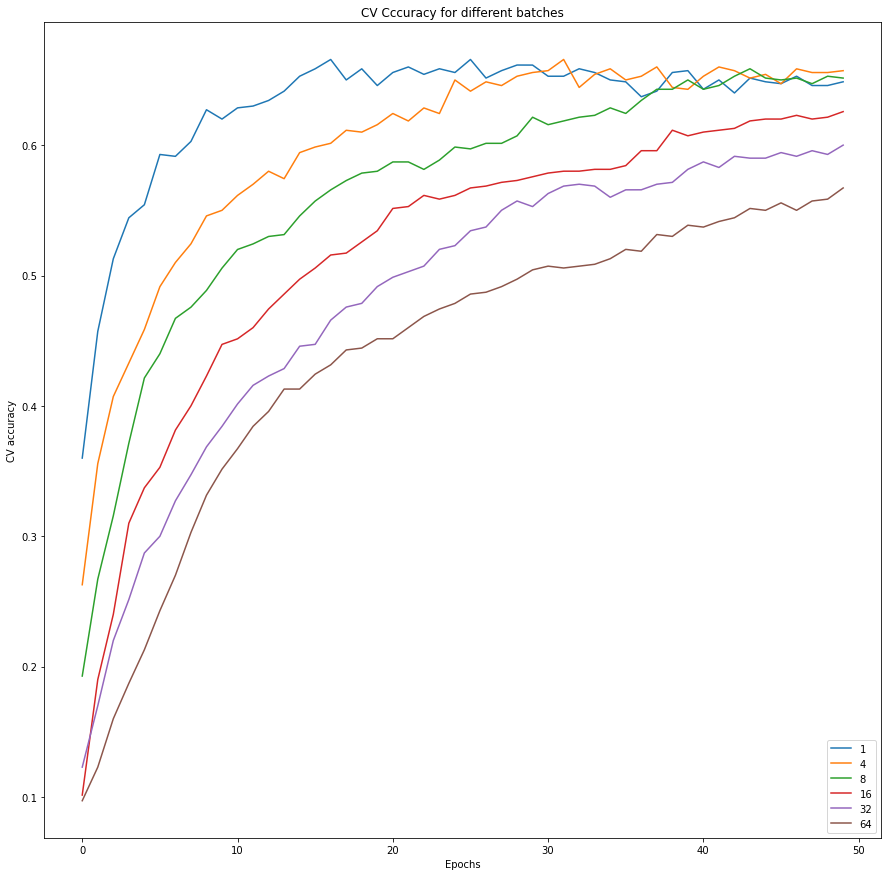

In [13]:
plt.figure(figsize=(15,15)) 

for key, value in accuracy_all.items():
    plt.plot(value)
    
    
plt.title('CV Cccuracy for different batches')
plt.ylabel('CV accuracy')
plt.xlabel('Epochs')

plt.legend(accuracy_all.keys(), loc='lower right')

In [14]:
accuracy_all

{1: array([0.3599709 , 0.45711211, 0.51283886, 0.5442757 , 0.55429002,
        0.59284937, 0.59141876, 0.60283923, 0.62715969, 0.6200005 ,
        0.62859641, 0.62999034, 0.63426385, 0.64141081, 0.65286183,
        0.65857818, 0.66571293, 0.65001283, 0.65855986, 0.645721  ,
        0.65572308, 0.65997825, 0.65430468, 0.65859654, 0.65571696,
        0.66571293, 0.65146178, 0.65714147, 0.66145164, 0.66141496,
        0.65286183, 0.65286795, 0.65859654, 0.65570472, 0.65001893,
        0.64856388, 0.63713117, 0.64143527, 0.65573531, 0.65714147,
        0.642872  , 0.65000671, 0.64002299, 0.6514557 , 0.64860668,
        0.64716383, 0.65287407, 0.64573934, 0.64573934, 0.64860056]),
 4: array([0.26281135, 0.35569739, 0.40715675, 0.43286502, 0.45857941,
        0.49144076, 0.51000209, 0.52430212, 0.54571855, 0.5500104 ,
        0.56144309, 0.56997786, 0.57999218, 0.57426971, 0.59427389,
        0.5985657 , 0.60142696, 0.6114107 , 0.60998617, 0.61570255,
        0.62428621, 0.61853931, 0.628535

## Part (b) 

Create a table of median time taken to train the network for one epoch
against different batch sizes.

In [16]:
time_table = pd.DataFrame.from_dict(time_taken_all, orient='index')
time_table.columns = ['Median Time per epoch (s)']

time_table['Batch Size'] = time_table.index
time_table.index = np.arange(len(time_table))

time_table = pd.DataFrame([time_table['Batch Size'], time_table['Median Time per epoch (s)']]).T
time_table['Batch Size'] = time_table['Batch Size'].astype('int64')
time_table

,Batch Size,Median Time per epoch (s)
0,1,0.358664
1,4,0.092834
2,8,0.060493
3,16,0.039668
4,32,0.027656
5,64,0.020665


## Part (c) 

Select the optimal batch size and state reasons for your selection. 

Assumption: The question asks us to train the model for 50 epochs. After examining the plot, I do not think that the models with with 16,32 and 64 batch size have converged withtin 50 epochs. I am making an assumption that they converge at the maximum epoch possible that is 50.

In [17]:
time_table['Approx. Convergence epoch'] = [15, 30, 45, 50, 50, 50]
time_table['Time Taken for Convergence (s)'] = time_table['Approx. Convergence epoch'] * time_table['Median Time per epoch (s)']
time_table['Approx. Maximum CV Accuracy'] = [65, 66, 65, 62, 60, 57]

In [19]:
time_table

,Batch Size,Median Time per epoch (s),Approx. Convergence epoch,Time Taken for Convergence (s),Approx. Maximum CV Accuracy
0,1,0.358664,15,5.379965,65
1,4,0.092834,30,2.785034,66
2,8,0.060493,45,2.722178,65
3,16,0.039668,50,1.983388,62
4,32,0.027656,50,1.382782,60
5,64,0.020665,50,1.033241,57


- Column 1: Batch size passed to the model.

- Column 2: The median time taken per epoch which is calculated during model training with a callback.

- Column 3: The approx convergence epoch observed for the models from the plotted graph.

- Column 4: The time taken for convergence. (Multiply column 2 and column 3)

- Column 5: The maximum accuracy achieved from the models as observed from the plotted graph. 

#### Insights:

The optimal batch size is <b>8</b> as the model has a far better accuracy than the models with batch size 16,32 and 64. The model also has same/similar accuracy with the models of batch size of 1 and 4 but has a lower time taken for convergence.<br>

It can be seen that as the batch size grows, the time taken decreases. Because the weights are updated n/batch size times for each epoch, where n is the number of data points, this is the case. As the batch size grows, the number of weight updates lowers, resulting in fewer calculations and hence less time.<br>

We can see that as the batch size grows, so does the convergence epoch. Because weights are updated more frequently in one epoch when the batch size is small, the data is fit in fewer epochs. <br>

## Part (d) 

What is the difference between mini-batch gradient descent and stochastic
gradient descent and what does this mean for model training?

#### Mini-Batch Gradient Descent

- We take a subset/batch of data and update the parameters based on every batch.
- The cost function updation  is smoother as compared to that of the cost function in SGD. Since we’re not updating the parameters after every single observation but after every batch of the data.

#### Stochastic Gradient Descent(Special case of Mini-Batch gradient Descent with batch size of 1)

- We update the parameters after every single observation.
- The cost function updation is not smooth. Since we’re updating the parameters based on a single observation, there are a lot of iterations. It might also be possible that the model starts learning noise as well.

This confirms our findings and analysis in the preceding section of this topic, in which we attempted to determine the best batch size, i.e., the time required for model training per epoch decreases as batch size grows, and convergence occurs in fewer epochs with smaller batches. <br>



## Part (e) 

Plot the train and test accuracies against epochs for the optimal batch size. 

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(16 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 8 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>

In [20]:
# Sequential Model
model = Sequential()

model.add(Dense(16, input_shape=(X_train.shape[1],), activation="relu")) 
model.add(Dropout(0.3))                                                  
model.add(Dense(10, activation="softmax"))                               

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,  
                    batch_size=8,      
                    epochs=50,         
                    validation_data=(X_test, y_test),  
                   )  

Epoch 1/50
88/88 [==============================] - 0s 2ms/step - loss: 2.5475 - accuracy: 0.1400 - val_loss: 2.2650 - val_accuracy: 0.2067
Epoch 2/50
88/88 [==============================] - 0s 718us/step - loss: 2.1395 - accuracy: 0.2257 - val_loss: 1.9820 - val_accuracy: 0.3333
Epoch 3/50
88/88 [==============================] - 0s 772us/step - loss: 1.8815 - accuracy: 0.3043 - val_loss: 1.7997 - val_accuracy: 0.3567
Epoch 4/50
88/88 [==============================] - 0s 754us/step - loss: 1.7395 - accuracy: 0.3557 - val_loss: 1.6750 - val_accuracy: 0.3967
Epoch 5/50
88/88 [==============================] - 0s 746us/step - loss: 1.6020 - accuracy: 0.4229 - val_loss: 1.5852 - val_accuracy: 0.4100
Epoch 6/50
88/88 [==============================] - 0s 713us/step - loss: 1.5375 - accuracy: 0.4229 - val_loss: 1.5125 - val_accuracy: 0.4233
Epoch 7/50
88/88 [==============================] - 0s 760us/step - loss: 1.4530 - accuracy: 0.4586 - val_loss: 1.4590 - val_accuracy: 0.4467
Epoch 8/

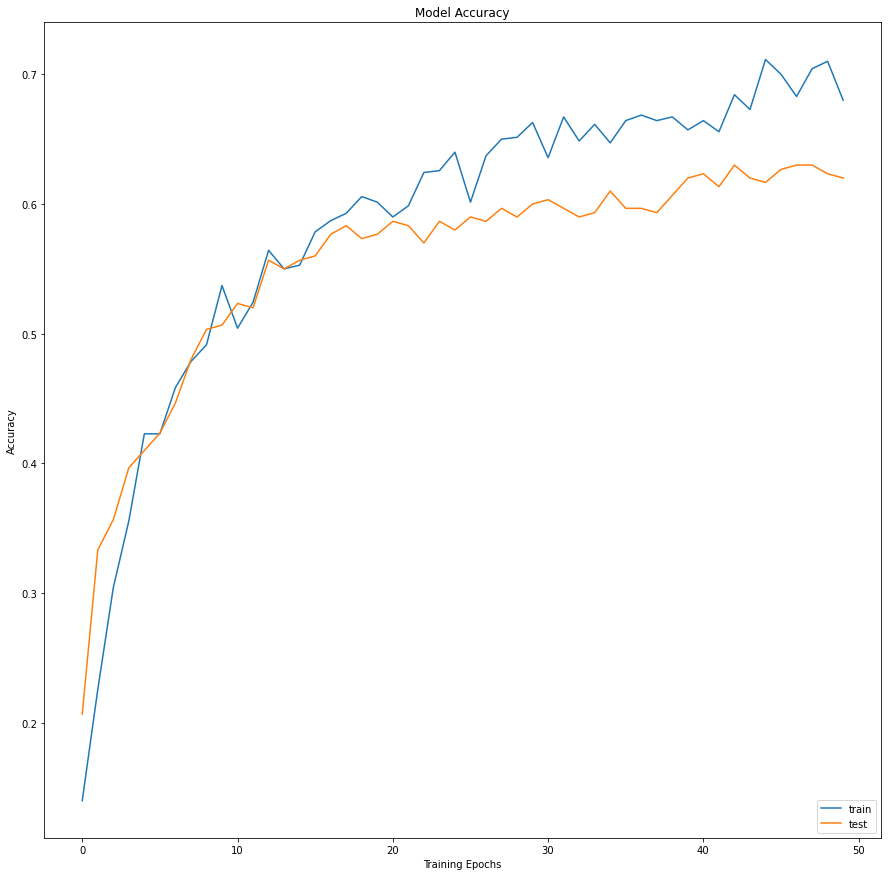

In [21]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')

plt.legend(['train', 'test'], loc='lower right')

# Question 3

Find the optimal number of hidden neurons for the 2-layer network (i.e., one hidden
layer) designed in Question 1 and 2

----------------------------------------------------------------------------------------------

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer([8/16/32/64] neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 8 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>
<b>Cross Validation(KFold)</b>: 3-fold CV used for parameter selection

In [22]:
accuracy_all = {}
loss_all = {}

neurons_list = [8, 16, 32, 64]
for neurons in neurons_list:

    accuracy = []
    loss = []

    kfold = KFold(n_splits=3, random_state=1, shuffle=True)

    for train_index, test_index in kfold.split(X_train):

        model = Sequential()
        
        model.add(Dense(neurons, input_shape=(X_train.shape[1],), activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(10, activation="softmax"))    
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train[train_index], y_train[train_index],
            batch_size=8,
            epochs=50,
            validation_data=(X_train[test_index], y_train[test_index]),
            validation_batch_size=batch
        )

        accuracy.append(history.history['val_accuracy'])
        loss.append(history.history['val_loss'])

    accuracy_all[neurons] = np.array(accuracy).mean(axis=0)
    loss_all[neurons] = np.array(loss).mean(axis=0)



Epoch 1/50
59/59 [==============================] - 0s 2ms/step - loss: 2.5203 - accuracy: 0.1030 - val_loss: 2.3759 - val_accuracy: 0.1795
Epoch 2/50
59/59 [==============================] - 0s 772us/step - loss: 2.3831 - accuracy: 0.1330 - val_loss: 2.2430 - val_accuracy: 0.1795
Epoch 3/50
59/59 [==============================] - 0s 677us/step - loss: 2.2224 - accuracy: 0.1524 - val_loss: 2.1467 - val_accuracy: 0.2094
Epoch 4/50
59/59 [==============================] - 0s 707us/step - loss: 2.1089 - accuracy: 0.1974 - val_loss: 2.0655 - val_accuracy: 0.2436
Epoch 5/50
59/59 [==============================] - 0s 682us/step - loss: 2.0110 - accuracy: 0.2403 - val_loss: 1.9794 - val_accuracy: 0.2821
Epoch 6/50
59/59 [==============================] - 0s 664us/step - loss: 1.9500 - accuracy: 0.3047 - val_loss: 1.8992 - val_accuracy: 0.3291
Epoch 7/50
59/59 [==============================] - 0s 731us/step - loss: 1.8503 - accuracy: 0.3305 - val_loss: 1.8370 - val_accuracy: 0.3462
Epoch 8/

59/59 [==============================] - 0s 660us/step - loss: 1.8062 - accuracy: 0.3512 - val_loss: 1.7395 - val_accuracy: 0.4163
Epoch 9/50
59/59 [==============================] - 0s 720us/step - loss: 1.7813 - accuracy: 0.3533 - val_loss: 1.6983 - val_accuracy: 0.4335
Epoch 10/50
59/59 [==============================] - 0s 671us/step - loss: 1.7483 - accuracy: 0.3597 - val_loss: 1.6563 - val_accuracy: 0.4464
Epoch 11/50
59/59 [==============================] - 0s 693us/step - loss: 1.6925 - accuracy: 0.3833 - val_loss: 1.6276 - val_accuracy: 0.4549
Epoch 12/50
59/59 [==============================] - 0s 661us/step - loss: 1.6589 - accuracy: 0.3961 - val_loss: 1.5940 - val_accuracy: 0.4592
Epoch 13/50
59/59 [==============================] - 0s 704us/step - loss: 1.6187 - accuracy: 0.3897 - val_loss: 1.5612 - val_accuracy: 0.4850
Epoch 14/50
59/59 [==============================] - 0s 661us/step - loss: 1.6500 - accuracy: 0.3812 - val_loss: 1.5385 - val_accuracy: 0.4936
Epoch 15/50


59/59 [==============================] - 0s 669us/step - loss: 1.6250 - accuracy: 0.4133 - val_loss: 1.5482 - val_accuracy: 0.5193
Epoch 16/50
59/59 [==============================] - 0s 687us/step - loss: 1.5735 - accuracy: 0.3961 - val_loss: 1.5262 - val_accuracy: 0.5236
Epoch 17/50
59/59 [==============================] - 0s 673us/step - loss: 1.5792 - accuracy: 0.4240 - val_loss: 1.5015 - val_accuracy: 0.5279
Epoch 18/50
59/59 [==============================] - 0s 695us/step - loss: 1.5502 - accuracy: 0.4411 - val_loss: 1.4796 - val_accuracy: 0.5536
Epoch 19/50
59/59 [==============================] - 0s 633us/step - loss: 1.5306 - accuracy: 0.4433 - val_loss: 1.4613 - val_accuracy: 0.5536
Epoch 20/50
59/59 [==============================] - 0s 649us/step - loss: 1.5285 - accuracy: 0.4347 - val_loss: 1.4473 - val_accuracy: 0.5579
Epoch 21/50
59/59 [==============================] - 0s 678us/step - loss: 1.5027 - accuracy: 0.4325 - val_loss: 1.4333 - val_accuracy: 0.5622
Epoch 22/50

59/59 [==============================] - 0s 678us/step - loss: 1.2273 - accuracy: 0.5622 - val_loss: 1.2138 - val_accuracy: 0.5769
Epoch 23/50
59/59 [==============================] - 0s 627us/step - loss: 1.2117 - accuracy: 0.5451 - val_loss: 1.2014 - val_accuracy: 0.5769
Epoch 24/50
59/59 [==============================] - 0s 627us/step - loss: 1.2119 - accuracy: 0.5751 - val_loss: 1.2005 - val_accuracy: 0.5726
Epoch 25/50
59/59 [==============================] - 0s 661us/step - loss: 1.2016 - accuracy: 0.5773 - val_loss: 1.1876 - val_accuracy: 0.5726
Epoch 26/50
59/59 [==============================] - 0s 644us/step - loss: 1.1411 - accuracy: 0.5794 - val_loss: 1.1792 - val_accuracy: 0.5897
Epoch 27/50
59/59 [==============================] - 0s 627us/step - loss: 1.1206 - accuracy: 0.6202 - val_loss: 1.1642 - val_accuracy: 0.5940
Epoch 28/50
59/59 [==============================] - 0s 644us/step - loss: 1.1301 - accuracy: 0.6094 - val_loss: 1.1526 - val_accuracy: 0.5940
Epoch 29/50

Epoch 28/50
59/59 [==============================] - 0s 653us/step - loss: 1.0054 - accuracy: 0.6338 - val_loss: 1.0909 - val_accuracy: 0.6524
Epoch 29/50
59/59 [==============================] - 0s 644us/step - loss: 1.0295 - accuracy: 0.6488 - val_loss: 1.0853 - val_accuracy: 0.6524
Epoch 30/50
59/59 [==============================] - 0s 691us/step - loss: 0.9960 - accuracy: 0.6403 - val_loss: 1.0798 - val_accuracy: 0.6395
Epoch 31/50
59/59 [==============================] - 0s 665us/step - loss: 1.0132 - accuracy: 0.6124 - val_loss: 1.0758 - val_accuracy: 0.6524
Epoch 32/50
59/59 [==============================] - 0s 724us/step - loss: 0.9986 - accuracy: 0.6467 - val_loss: 1.0749 - val_accuracy: 0.6481
Epoch 33/50
59/59 [==============================] - 0s 663us/step - loss: 0.9531 - accuracy: 0.6510 - val_loss: 1.0694 - val_accuracy: 0.6481
Epoch 34/50
59/59 [==============================] - 0s 661us/step - loss: 0.9556 - accuracy: 0.6360 - val_loss: 1.0698 - val_accuracy: 0.6481

59/59 [==============================] - 0s 661us/step - loss: 1.0246 - accuracy: 0.6274 - val_loss: 1.0380 - val_accuracy: 0.6524
Epoch 36/50
59/59 [==============================] - 0s 638us/step - loss: 1.0534 - accuracy: 0.6124 - val_loss: 1.0309 - val_accuracy: 0.6524
Epoch 37/50
59/59 [==============================] - 0s 645us/step - loss: 1.0276 - accuracy: 0.6338 - val_loss: 1.0251 - val_accuracy: 0.6524
Epoch 38/50
59/59 [==============================] - 0s 666us/step - loss: 0.9905 - accuracy: 0.6531 - val_loss: 1.0246 - val_accuracy: 0.6567
Epoch 39/50
59/59 [==============================] - 0s 678us/step - loss: 0.9843 - accuracy: 0.6317 - val_loss: 1.0227 - val_accuracy: 0.6438
Epoch 40/50
59/59 [==============================] - 0s 634us/step - loss: 0.9455 - accuracy: 0.6681 - val_loss: 1.0153 - val_accuracy: 0.6223
Epoch 41/50
59/59 [==============================] - 0s 712us/step - loss: 0.9795 - accuracy: 0.6574 - val_loss: 1.0097 - val_accuracy: 0.6438
Epoch 42/50

59/59 [==============================] - 0s 712us/step - loss: 0.6091 - accuracy: 0.7790 - val_loss: 0.9783 - val_accuracy: 0.6923
Epoch 43/50
59/59 [==============================] - 0s 661us/step - loss: 0.6015 - accuracy: 0.8026 - val_loss: 0.9923 - val_accuracy: 0.6795
Epoch 44/50
59/59 [==============================] - 0s 678us/step - loss: 0.5606 - accuracy: 0.8004 - val_loss: 1.0139 - val_accuracy: 0.6795
Epoch 45/50
59/59 [==============================] - 0s 675us/step - loss: 0.5915 - accuracy: 0.7897 - val_loss: 1.0015 - val_accuracy: 0.6752
Epoch 46/50
59/59 [==============================] - 0s 701us/step - loss: 0.5826 - accuracy: 0.7897 - val_loss: 1.0145 - val_accuracy: 0.6838
Epoch 47/50
59/59 [==============================] - 0s 706us/step - loss: 0.5438 - accuracy: 0.8004 - val_loss: 0.9990 - val_accuracy: 0.6966
Epoch 48/50
59/59 [==============================] - 0s 644us/step - loss: 0.5365 - accuracy: 0.8305 - val_loss: 0.9995 - val_accuracy: 0.6838
Epoch 49/50

59/59 [==============================] - 0s 678us/step - loss: 0.5238 - accuracy: 0.8094 - val_loss: 1.0012 - val_accuracy: 0.6824
Epoch 50/50
59/59 [==============================] - 0s 704us/step - loss: 0.5584 - accuracy: 0.8116 - val_loss: 0.9905 - val_accuracy: 0.6824
Epoch 1/50
59/59 [==============================] - 0s 2ms/step - loss: 2.6169 - accuracy: 0.1392 - val_loss: 2.1071 - val_accuracy: 0.2747
Epoch 2/50
59/59 [==============================] - 0s 694us/step - loss: 2.0108 - accuracy: 0.2912 - val_loss: 1.8106 - val_accuracy: 0.4077
Epoch 3/50
59/59 [==============================] - 0s 610us/step - loss: 1.7507 - accuracy: 0.4047 - val_loss: 1.6339 - val_accuracy: 0.4592
Epoch 4/50
59/59 [==============================] - 0s 661us/step - loss: 1.6206 - accuracy: 0.4325 - val_loss: 1.5204 - val_accuracy: 0.4635
Epoch 5/50
59/59 [==============================] - 0s 644us/step - loss: 1.5223 - accuracy: 0.4647 - val_loss: 1.4418 - val_accuracy: 0.4979
Epoch 6/50
59/59 [

59/59 [==============================] - 0s 712us/step - loss: 1.1417 - accuracy: 0.5944 - val_loss: 1.2195 - val_accuracy: 0.5470
Epoch 7/50
59/59 [==============================] - 0s 677us/step - loss: 1.0518 - accuracy: 0.6631 - val_loss: 1.1704 - val_accuracy: 0.5855
Epoch 8/50
59/59 [==============================] - 0s 690us/step - loss: 0.9755 - accuracy: 0.6845 - val_loss: 1.1453 - val_accuracy: 0.5897
Epoch 9/50
59/59 [==============================] - 0s 672us/step - loss: 0.9292 - accuracy: 0.6910 - val_loss: 1.1216 - val_accuracy: 0.6068
Epoch 10/50
59/59 [==============================] - 0s 705us/step - loss: 0.9031 - accuracy: 0.7039 - val_loss: 1.0807 - val_accuracy: 0.6325
Epoch 11/50
59/59 [==============================] - 0s 675us/step - loss: 0.8664 - accuracy: 0.7167 - val_loss: 1.0580 - val_accuracy: 0.6197
Epoch 12/50
59/59 [==============================] - 0s 693us/step - loss: 0.8538 - accuracy: 0.7060 - val_loss: 1.0552 - val_accuracy: 0.6368
Epoch 13/50
59

59/59 [==============================] - 0s 791us/step - loss: 0.7431 - accuracy: 0.7645 - val_loss: 0.9960 - val_accuracy: 0.6738
Epoch 14/50
59/59 [==============================] - 0s 748us/step - loss: 0.7064 - accuracy: 0.7687 - val_loss: 0.9912 - val_accuracy: 0.6695
Epoch 15/50
59/59 [==============================] - 0s 1ms/step - loss: 0.7155 - accuracy: 0.7666 - val_loss: 0.9733 - val_accuracy: 0.6738
Epoch 16/50
59/59 [==============================] - 0s 708us/step - loss: 0.7234 - accuracy: 0.7345 - val_loss: 0.9707 - val_accuracy: 0.6781
Epoch 17/50
59/59 [==============================] - 0s 716us/step - loss: 0.6696 - accuracy: 0.7816 - val_loss: 0.9700 - val_accuracy: 0.6652
Epoch 18/50
59/59 [==============================] - 0s 734us/step - loss: 0.6431 - accuracy: 0.7859 - val_loss: 0.9531 - val_accuracy: 0.6738
Epoch 19/50
59/59 [==============================] - 0s 699us/step - loss: 0.6196 - accuracy: 0.7966 - val_loss: 0.9553 - val_accuracy: 0.6824
Epoch 20/50
5

59/59 [==============================] - 0s 734us/step - loss: 0.6059 - accuracy: 0.8137 - val_loss: 0.8594 - val_accuracy: 0.7511
Epoch 21/50
59/59 [==============================] - 0s 711us/step - loss: 0.5998 - accuracy: 0.8073 - val_loss: 0.8536 - val_accuracy: 0.7339
Epoch 22/50
59/59 [==============================] - 0s 701us/step - loss: 0.5574 - accuracy: 0.8137 - val_loss: 0.8576 - val_accuracy: 0.7124
Epoch 23/50
59/59 [==============================] - 0s 689us/step - loss: 0.5530 - accuracy: 0.8308 - val_loss: 0.8452 - val_accuracy: 0.7339
Epoch 24/50
59/59 [==============================] - 0s 679us/step - loss: 0.5338 - accuracy: 0.8244 - val_loss: 0.8403 - val_accuracy: 0.7425
Epoch 25/50
59/59 [==============================] - 0s 661us/step - loss: 0.5127 - accuracy: 0.8373 - val_loss: 0.8296 - val_accuracy: 0.7339
Epoch 26/50
59/59 [==============================] - 0s 737us/step - loss: 0.5061 - accuracy: 0.8522 - val_loss: 0.8343 - val_accuracy: 0.7468
Epoch 27/50

## Part (a) 

Plot the cross-validation accuracies against training epochs for different
numbers of hidden-layer neurons. Limit the search space of the number of
neurons to {8, 16, 32, 64}.
Continue using 3-fold cross validation on training dataset.

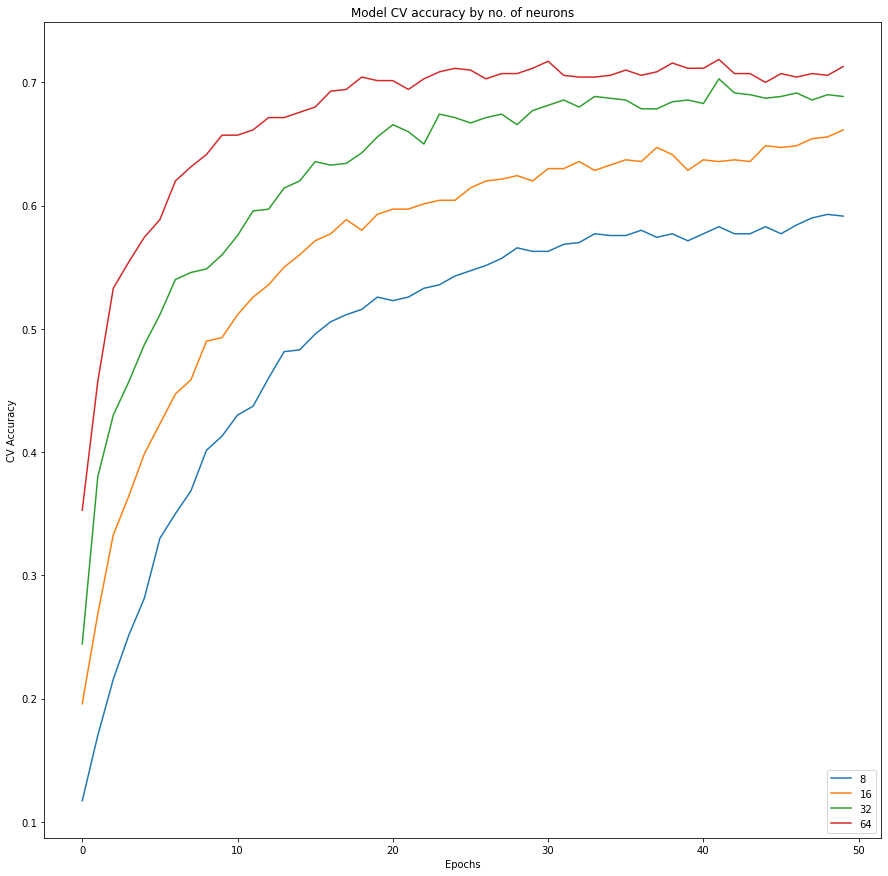

In [24]:
plt.figure(figsize=(15,15)) 

for key, value in accuracy_all.items():
    plt.plot(value);
    
plt.title('Model CV accuracy by no. of neurons')
plt.ylabel('CV Accuracy')
plt.xlabel('Epochs')

plt.legend(accuracy_all.keys(), loc='lower right')

## Part (b) 

Select the optimal number of neurons for the hidden layer. State the
rationale for your selection.

#### Insights:

- I think the optimal number of neurons is <b>64</b> as it gives the highest CV accuracy after converging. 

## Part (c)

Plot the train and test accuracies against training epochs with the optimal
number of neurons.

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(64 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 8 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>

In [34]:
model = Sequential()

model.add(Dense(64, input_shape=(X_train.shape[1],), activation="relu")) 
model.add(Dropout(0.3))                                                  
model.add(Dense(10, activation="softmax"))                               

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,  
                    batch_size=8,      
                    epochs=50,         
                    validation_data=(X_test, y_test),  
                   )  

Epoch 1/50
88/88 [==============================] - 0s 2ms/step - loss: 2.2033 - accuracy: 0.2529 - val_loss: 1.7088 - val_accuracy: 0.4133
Epoch 2/50
88/88 [==============================] - 0s 752us/step - loss: 1.5751 - accuracy: 0.4457 - val_loss: 1.4680 - val_accuracy: 0.5067
Epoch 3/50
88/88 [==============================] - 0s 737us/step - loss: 1.3468 - accuracy: 0.5186 - val_loss: 1.3431 - val_accuracy: 0.5233
Epoch 4/50
88/88 [==============================] - 0s 764us/step - loss: 1.2361 - accuracy: 0.5729 - val_loss: 1.2467 - val_accuracy: 0.5833
Epoch 5/50
88/88 [==============================] - 0s 817us/step - loss: 1.0959 - accuracy: 0.6186 - val_loss: 1.1830 - val_accuracy: 0.6100
Epoch 6/50
88/88 [==============================] - 0s 832us/step - loss: 1.0601 - accuracy: 0.6271 - val_loss: 1.1382 - val_accuracy: 0.6167
Epoch 7/50
88/88 [==============================] - 0s 774us/step - loss: 0.9609 - accuracy: 0.6757 - val_loss: 1.1013 - val_accuracy: 0.6233
Epoch 8/

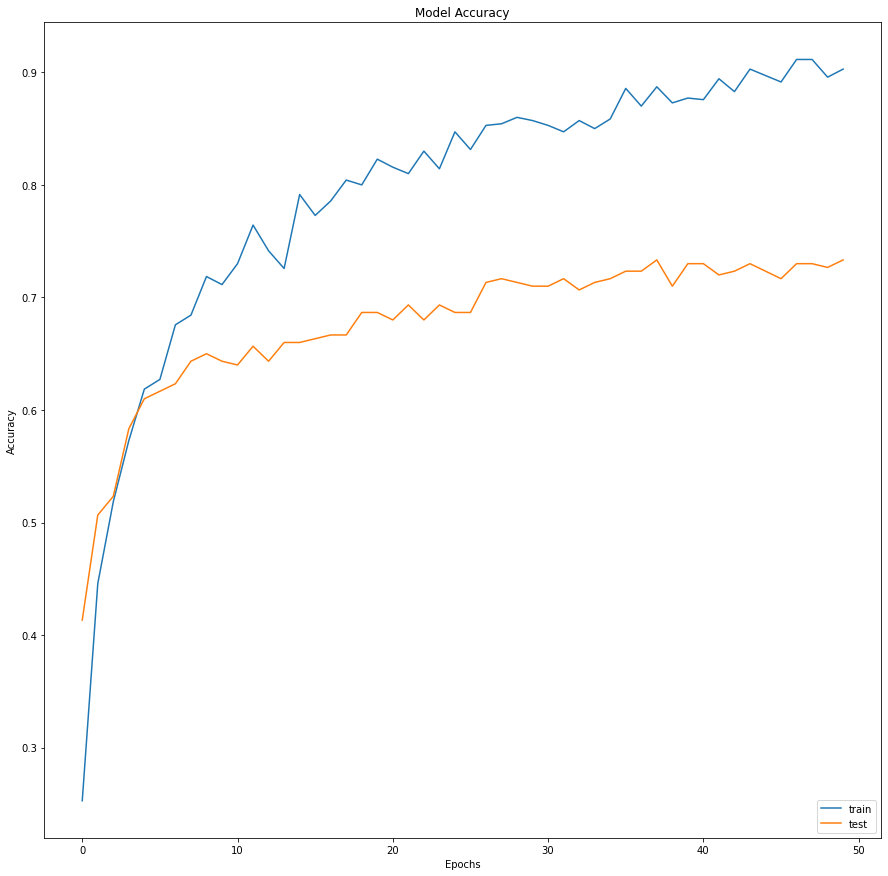

In [35]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='lower right')

In [36]:
history.history['accuracy'][45:]

[0.8914285898208618,
 0.9114285707473755,
 0.9114285707473755,
 0.895714282989502,
 0.9028571248054504]

In [37]:
history.history['val_accuracy'][45:]

[0.7166666388511658,
 0.7300000190734863,
 0.7300000190734863,
 0.7266666889190674,
 0.7333333492279053]

## Part (d)

What other parameters could possibly be tuned?

#### Insights:

- <b>Learning rate</b> - We can hypertune learning rate given to the optimizer.
- <b>Weight initialization technique</b> - We can hypertune various weight initialization technique like normal, uniform, glorot etc.
- <b>Optimizer</b> - We can hypertune and check the performance of various optimizers like Adam, Adagrad, RMSProp, etc.
- <b>Activation functions</b> - We can hypertune and check the performance of various activation functions like ELU, LeakyReLU, etc.

# Question 4

After you are done with the 2-layer network, design a 3-layer network with two hiddenlayers with ReLU activation, each consisting of the optimal number of neurons you
obtained in Question 3, (apply a dropout with a probability of 0.3 for each hidden layer),
and train it with a batch size of 1.

---------------------------------------------------------------------------------------------------------------------

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(64 neurons, 0.3 Dropout probability, ReLU activation)
- 1 hidden layer(64 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 1 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>

In [38]:
model = Sequential()

model.add(Dense(64, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))    

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
    batch_size=1,
    epochs=50,
    validation_data=(X_test, y_test))

Epoch 1/50
700/700 [==============================] - 1s 733us/step - loss: 1.9153 - accuracy: 0.3386 - val_loss: 1.4049 - val_accuracy: 0.4833
Epoch 2/50
700/700 [==============================] - 0s 577us/step - loss: 1.3889 - accuracy: 0.5243 - val_loss: 1.1940 - val_accuracy: 0.5733
Epoch 3/50
700/700 [==============================] - 0s 573us/step - loss: 1.2206 - accuracy: 0.5571 - val_loss: 1.1149 - val_accuracy: 0.6100
Epoch 4/50
700/700 [==============================] - 0s 570us/step - loss: 1.0734 - accuracy: 0.6257 - val_loss: 1.0612 - val_accuracy: 0.6267
Epoch 5/50
700/700 [==============================] - 0s 574us/step - loss: 1.0127 - accuracy: 0.6671 - val_loss: 1.0008 - val_accuracy: 0.6700
Epoch 6/50
700/700 [==============================] - 0s 591us/step - loss: 0.9121 - accuracy: 0.6857 - val_loss: 1.0091 - val_accuracy: 0.6433
Epoch 7/50
700/700 [==============================] - 0s 563us/step - loss: 0.7913 - accuracy: 0.7186 - val_loss: 0.9503 - val_accuracy:

## Part (a)

Plot the train and test accuracy of the 3-layer network against training
epochs.


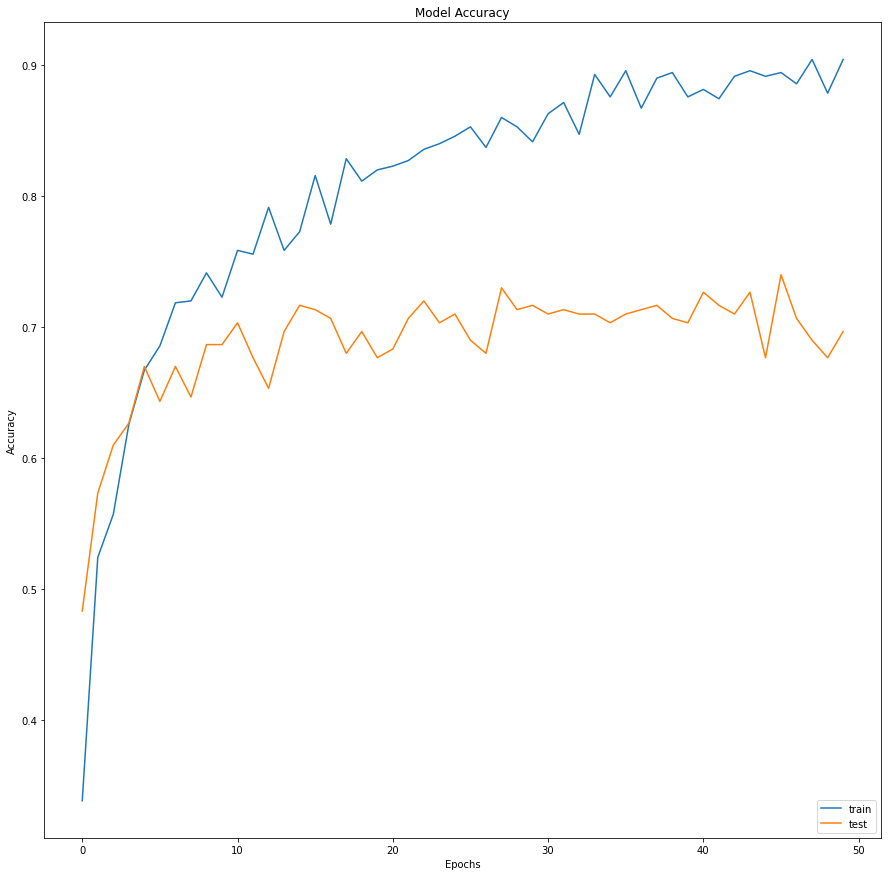

In [39]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='lower right')

In [40]:
history.history['accuracy'][45:]

[0.8942857384681702,
 0.8857142925262451,
 0.904285728931427,
 0.8785714507102966,
 0.904285728931427]

In [41]:
history.history['val_accuracy'][45:]

[0.7400000095367432,
 0.7066666483879089,
 0.6899999976158142,
 0.6766666769981384,
 0.6966666579246521]

## Part (b)

Compare and comment on the performances of the optimal 2-layer network
from your hyperparameter tuning in Question 2 and 3 and the 3-layer
network.

- I think the model with the optimized 2 layer network performs better than the 3 layer network by a small margin of approx 3% higher accuracy at the last epoch. This could also be the randomness of the model. Both the models seems to be performing equally well on the test data.

# Question 5

We are going to dissect the purpose of dropout in the model.

------------------------------------------------------------------------------------------------------------------------

<b>DNN architecture</b>: 
- input layer
- 1 hidden layer(16 neurons, 0.3 Dropout probability, ReLU activation)
- output layer(softmax activation)
- optimizer: Adam

<b>Batch Size</b>: 1 <br>
<b>Number of epochs</b>: 50 <br>
<b>Train-Test Data ratio</b>: 70:30 <br>

In [42]:
model = Sequential()

model.add(Dense(16, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(10, activation="softmax"))   

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
    batch_size=1,
    epochs=50,
    validation_data=(X_test, y_test))

Epoch 1/50
700/700 [==============================] - 0s 659us/step - loss: 2.0711 - accuracy: 0.2886 - val_loss: 1.5915 - val_accuracy: 0.4267
Epoch 2/50
700/700 [==============================] - 0s 540us/step - loss: 1.4225 - accuracy: 0.4900 - val_loss: 1.2957 - val_accuracy: 0.5433
Epoch 3/50
700/700 [==============================] - 0s 534us/step - loss: 1.1714 - accuracy: 0.6000 - val_loss: 1.1783 - val_accuracy: 0.5633
Epoch 4/50
700/700 [==============================] - 0s 546us/step - loss: 1.0068 - accuracy: 0.6743 - val_loss: 1.1082 - val_accuracy: 0.6067
Epoch 5/50
700/700 [==============================] - 0s 543us/step - loss: 0.8894 - accuracy: 0.7014 - val_loss: 1.0589 - val_accuracy: 0.6133
Epoch 6/50
700/700 [==============================] - 0s 538us/step - loss: 0.7926 - accuracy: 0.7414 - val_loss: 1.0504 - val_accuracy: 0.6200
Epoch 7/50
700/700 [==============================] - 0s 545us/step - loss: 0.7242 - accuracy: 0.7800 - val_loss: 1.0319 - val_accuracy:

## Part (a)

Why do we add dropouts? Investigate the purpose of dropouts by removing
dropouts from your original 2-layer network (before changing the batch size
and number of neurons). Plot accuracies on training and test data with neural
network without dropout. Plot as well the losses on training and test data with
neural network without dropout.

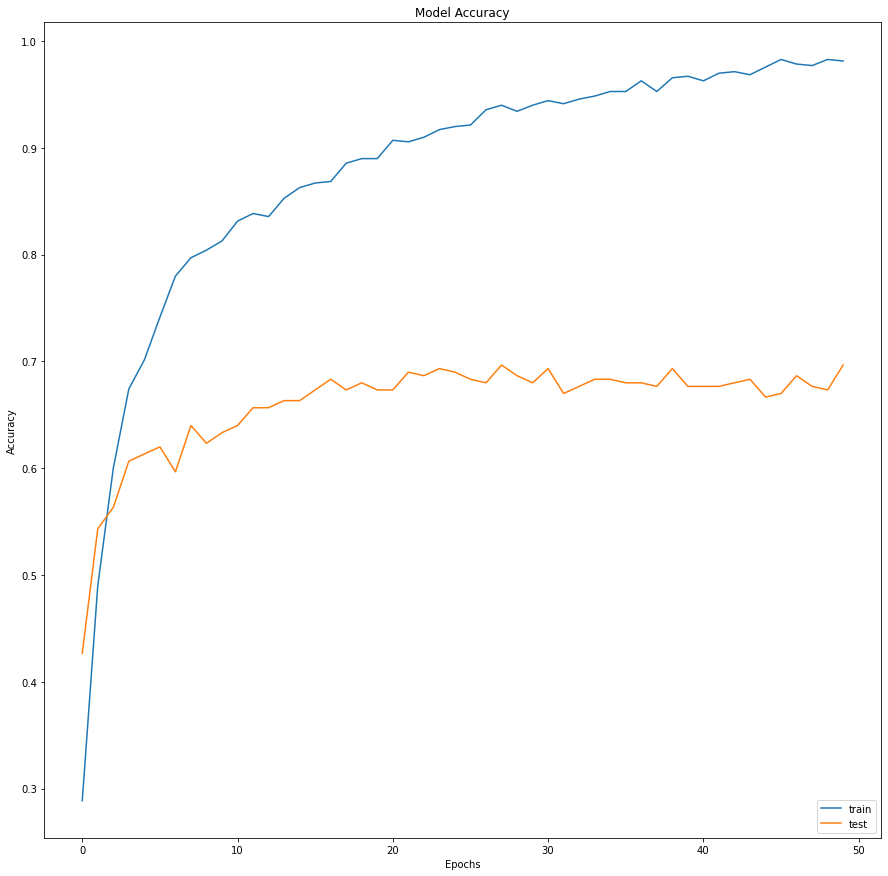

In [43]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='lower right')

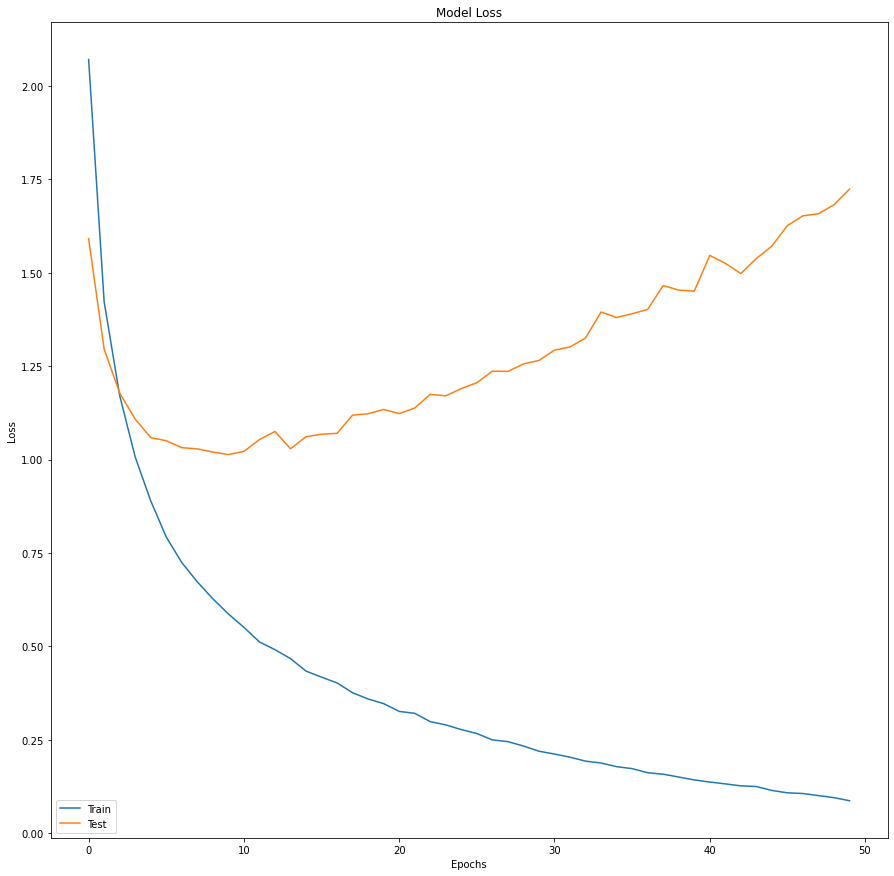

In [44]:
plt.figure(figsize=(15,15)) 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Test'], loc='lower left')

### Purpose of dropouts

Large neural nets trained on relatively small datasets can overfit the training data.<br>

This has the effect of the model learning the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g. a test dataset. Generalization error increases due to overfitting.<br>

By dropping a neuron, we mean temporarily removing it from the network, along with all its incoming and outgoing connections.<br>

Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.<br>

## Part (b)

Explain the effect of removing dropouts.

#### Insights:

Observation of the accuracy and loss plots:
1. There is a huge gap in the test and train accuracy.
2. The training loss keeps decreasing and testing loss starts to increase after 12/13 epochs. 

When dropouts are removed, the model becomes overfit to the data. By analyzing and comparing the accuracy and loss graphs in Question 1 with this question, the effect of deleting dropouts may be easily understood. The following observations demonstrate that the model does not overfit with dropout.

## Part (c)

What is another approach that you could take to address overfitting in the
model?


#### Insights:

- <b>Use Regularization</b>: Regularization is a strategy for reducing the model's complexity. It accomplishes this by incorporating a penalty term into the loss function. L1 and L2 regularization are the most frequent approaches.
  - The L1 penalty seeks to reduce the weights' absolute value. 
  - The L2 penalty seeks to reduce the weights' squared magnitude.
  
  

- <b>Early Stopping</b>: The number of training epochs to use is a difficulty when it comes to training neural network models.Overfitting the training dataset can come from using too many epochs, whereas using too few can result in an underfit model.Early stopping method allows to specify any large number of training epochs and then stop training once the model's performance on the validation data stops improving.<br>

     - The 'monitor' parameter allows to specify the performance measure to monitor in order to end training. We can check the loss on validation data or 'val_loss'.
     - The 'patience' parameter allows to delay the trigger of early stopping in terms of the number of epochs on which no improvement is seen. 

# Conclusion

- The feature engineering of the data includes scaling of the data. However, we have only used StandardScaler() which is one type of scaling method. We should try other variants of scaling such as MinMaxScaler, RobustScaler, etc.

  - Some scalers are sensitive to outliers, while others like RobustScaler are unaffected. Some scalers like Quantile Transformer Scaler alters the data's underlying distribution.

  - Each feature scaling strategy has unique properties that we can use to improve the model. However, picking the proper scaler, like other processes in developing a predictive model, is a trial and error process, and there is no single ideal scaler that works every time.
  
  
- Examine how to classify audio data using a combination of CNN and RNN. After additional examination, I've come to the conclusion that CNN makes sense because each spectogram is analogous to an image, with distinct patterns. RNN, on the other hand, excels in comprehending data in a sequential order. The spectograms have a time component, and RNNs can recognize the song's short- and long-term temporal aspects considerably more accurately.

- Use Max Pooling to your advantage. A pooling operation that determines the maximum value for patches of a feature map and uses it to build a downsampled (pooled) feature map is known as Max Pooling. After a CNN layer, this is used. This can assist us in selecting the most discriminative features for recognition from the entire audio signal.